# Basic Marketplace Simulation

Interactive demo of Stage 1 functionality - the core discrete-time marketplace simulation.

In [3]:
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
from market_sim.config import SimConfig
from market_sim.discrete import run_simulation, print_simulation_summary
from market_sim.entities import BookingEvent

## Basic Simulation Run

Let's run a basic simulation with default parameters and see what happens.

In [4]:
# Create configuration
config = SimConfig(
    horizon=1000,
    lambda_c=0.5,  # 0.5 nurses arrive per timestep on average
    mu=1.0,        # Shifts reopen after 1 time unit on average
    k=5,           # Nurses see top 5 shifts
    n_shifts=20,   # 20 total shifts
    random_seed=42
)

# Run simulation
result = run_simulation(config)

# Print summary
print_simulation_summary(result)

Simulation Summary:
  Total arrivals: 518
  Total bookings: 489
  Booking rate: 0.944
  Treated bookings: 489
  Control bookings: 0
  Treatment rate in bookings: 1.000


## Parameter Exploration

Let's see how different parameters affect the booking rate.

In [5]:
# Test different arrival rates
arrival_rates = [0.1, 0.3, 0.5, 0.7, 0.9]
booking_rates = []

for lambda_c in arrival_rates:
    config = SimConfig(
        horizon=1000,
        lambda_c=lambda_c,
        mu=1.0,
        k=5,
        n_shifts=20,
        random_seed=42
    )
    
    result = run_simulation(config)
    booking_rates.append(result.booking_rate)
    
    print(f"λ={lambda_c:.1f}: booking_rate={result.booking_rate:.3f}, "
          f"arrivals={result.total_arrivals}, bookings={result.total_bookings}")

λ=0.1: booking_rate=1.202, arrivals=84, bookings=101
λ=0.3: booking_rate=1.007, arrivals=300, bookings=302
λ=0.5: booking_rate=0.944, arrivals=518, bookings=489
λ=0.7: booking_rate=0.948, arrivals=715, bookings=678
λ=0.9: booking_rate=0.904, arrivals=926, bookings=837


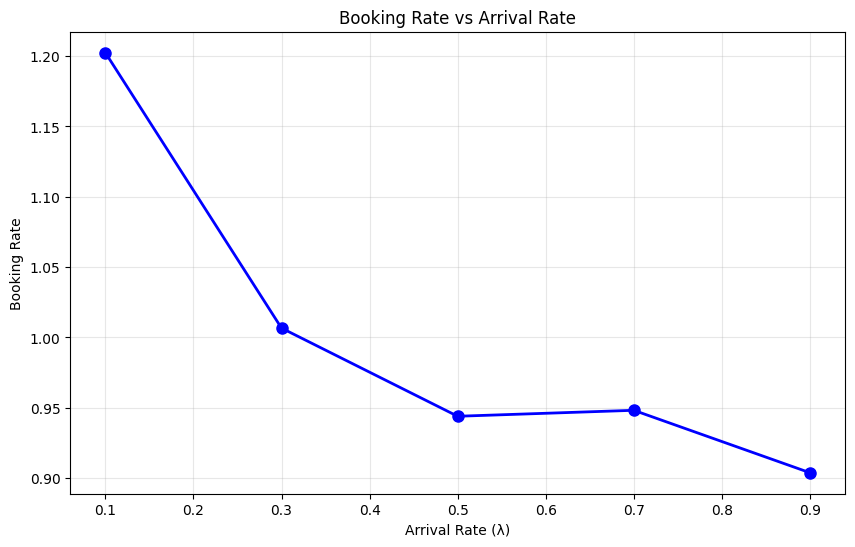

Observation: As arrival rate increases, booking rate should approach 1.0
This happens because more nurses are competing for the same shifts.


In [6]:
# Plot booking rate vs arrival rate
plt.figure(figsize=(10, 6))
plt.plot(arrival_rates, booking_rates, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Arrival Rate (λ)')
plt.ylabel('Booking Rate')
plt.title('Booking Rate vs Arrival Rate')
plt.grid(True, alpha=0.3)
plt.show()

print("Observation: As arrival rate increases, booking rate should approach 1.0")
print("This happens because more nurses are competing for the same shifts.")

## Treatment vs Control Analysis

Let's examine how treatment affects booking patterns.

In [7]:
# Run simulation with balanced treatment assignment
config = SimConfig(
    horizon=2000,
    lambda_c=0.6,
    mu=1.0,
    k=5,
    n_shifts=20,
    treatment_prob=0.5,  # 50% of shifts treated
    random_seed=42
)

result = run_simulation(config)
print_simulation_summary(result)

# Analyze treatment patterns
treated_events = [e for e in result.booking_events if e.shift_treated]
control_events = [e for e in result.booking_events if not e.shift_treated]

print(f"\nTreatment Analysis:")
print(f"Treated shift bookings: {len(treated_events)}")
print(f"Control shift bookings: {len(control_events)}")

if len(treated_events) > 0 and len(control_events) > 0:
    ratio = len(treated_events) / len(control_events)
    print(f"Treated:Control ratio: {ratio:.2f}")
    
    if ratio > 1.1:
        print("✓ Treated shifts are being booked more often (interference detected!)")
    elif ratio < 0.9:
        print("⚠ Control shifts are being booked more often (unexpected)")
    else:
        print("≈ Similar booking rates (may need longer simulation)")

Simulation Summary:
  Total arrivals: 1193
  Total bookings: 1086
  Booking rate: 0.910
  Treated bookings: 1086
  Control bookings: 0
  Treatment rate in bookings: 1.000

Treatment Analysis:
Treated shift bookings: 1086
Control shift bookings: 0


## Choice Position Analysis

Let's see where in the consideration set nurses are making their choices.

In [ ]:
# Analyze choice positions
positions = [event.choice_position for event in result.booking_events]
position_counts = {}

for pos in positions:
    position_counts[pos] = position_counts.get(pos, 0) + 1

print("Choice Position Distribution:")
for pos in sorted(position_counts.keys()):
    count = position_counts[pos]
    percentage = 100 * count / len(positions)
    print(f"Position {pos}: {count:4d} bookings ({percentage:5.1f}%)")

# Plot position distribution
plt.figure(figsize=(10, 6))
positions_list = sorted(position_counts.keys())
counts_list = [position_counts[pos] for pos in positions_list]

bars = plt.bar(positions_list, counts_list, alpha=0.7)
plt.xlabel('Position in Consideration Set')
plt.ylabel('Number of Bookings')
plt.title('Booking Distribution by Choice Position')
plt.xticks(positions_list)

# Add percentage labels on bars
total = sum(counts_list)
for i, (pos, count) in enumerate(zip(positions_list, counts_list)):
    percentage = 100 * count / total
    plt.text(pos, count + max(counts_list) * 0.01, f'{percentage:.1f}%', 
             ha='center', va='bottom')

plt.grid(True, alpha=0.3)
plt.show()

print("\nExpected: Position 0 (first) should have the most bookings")
print("This validates our position-weighted choice model.")

## Utility Distribution Analysis

Let's examine the distribution of shift utilities and how they relate to bookings.

In [ ]:
# Analyze utility patterns in bookings
utilities = [event.shift_utility for event in result.booking_events]

plt.figure(figsize=(12, 5))

# Histogram of booked shift utilities
plt.subplot(1, 2, 1)
plt.hist(utilities, bins=20, alpha=0.7, edgecolor='black')
plt.xlabel('Shift Utility')
plt.ylabel('Number of Bookings')
plt.title('Distribution of Booked Shift Utilities')
plt.grid(True, alpha=0.3)

# Box plot comparing treated vs control utilities
plt.subplot(1, 2, 2)
treated_utilities = [e.shift_utility for e in result.booking_events if e.shift_treated]
control_utilities = [e.shift_utility for e in result.booking_events if not e.shift_treated]

data_to_plot = [treated_utilities, control_utilities]
labels = ['Treated', 'Control']

plt.boxplot(data_to_plot, labels=labels)
plt.ylabel('Shift Utility')
plt.title('Utility Distribution: Treated vs Control')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Utility Statistics:")
print(f"All bookings - Mean: {np.mean(utilities):.3f}, Std: {np.std(utilities):.3f}")
if treated_utilities:
    print(f"Treated bookings - Mean: {np.mean(treated_utilities):.3f}, Std: {np.std(treated_utilities):.3f}")
if control_utilities:
    print(f"Control bookings - Mean: {np.mean(control_utilities):.3f}, Std: {np.std(control_utilities):.3f}")

## Timing Analysis

Let's look at when bookings happen over the course of the simulation.

In [ ]:
# Plot booking events over time
timestamps = [event.timestamp for event in result.booking_events]

plt.figure(figsize=(12, 6))

# Histogram of booking times
plt.subplot(2, 1, 1)
plt.hist(timestamps, bins=50, alpha=0.7, edgecolor='black')
plt.xlabel('Time (simulation steps)')
plt.ylabel('Number of Bookings')
plt.title('Booking Distribution Over Time')
plt.grid(True, alpha=0.3)

# Cumulative bookings over time
plt.subplot(2, 1, 2)
sorted_times = sorted(timestamps)
cumulative_bookings = list(range(1, len(sorted_times) + 1))

plt.plot(sorted_times, cumulative_bookings, 'b-', linewidth=2)
plt.xlabel('Time (simulation steps)')
plt.ylabel('Cumulative Bookings')
plt.title('Cumulative Bookings Over Time')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Timing Statistics:")
print(f"First booking at: t={min(timestamps):.1f}")
print(f"Last booking at: t={max(timestamps):.1f}")
print(f"Average booking time: t={np.mean(timestamps):.1f}")

## Experiment with Different Market Conditions

Let's create different market scenarios and compare results.

In [ ]:
# Define different market scenarios
scenarios = {
    'Low Demand': SimConfig(horizon=1000, lambda_c=0.2, mu=1.0, k=5, n_shifts=20, random_seed=42),
    'Balanced': SimConfig(horizon=1000, lambda_c=0.5, mu=1.0, k=5, n_shifts=20, random_seed=42),
    'High Demand': SimConfig(horizon=1000, lambda_c=0.8, mu=1.0, k=5, n_shifts=20, random_seed=42),
    'Fast Turnover': SimConfig(horizon=1000, lambda_c=0.5, mu=2.0, k=5, n_shifts=20, random_seed=42),
    'Slow Turnover': SimConfig(horizon=1000, lambda_c=0.5, mu=0.5, k=5, n_shifts=20, random_seed=42),
}

results = {}

print("Market Scenario Comparison:")
print("=" * 60)

for name, config in scenarios.items():
    result = run_simulation(config)
    results[name] = result
    
    treated_bookings = sum(1 for e in result.booking_events if e.shift_treated)
    control_bookings = result.total_bookings - treated_bookings
    
    print(f"{name:15s}: rate={result.booking_rate:.3f}, "
          f"treated={treated_bookings:3d}, control={control_bookings:3d}, "
          f"ratio={treated_bookings/max(control_bookings,1):.2f}")

In [ ]:
# Visualize scenario comparison
scenario_names = list(results.keys())
booking_rates = [results[name].booking_rate for name in scenario_names]
treated_ratios = []

for name in scenario_names:
    result = results[name]
    treated = sum(1 for e in result.booking_events if e.shift_treated)
    control = result.total_bookings - treated
    ratio = treated / max(control, 1)
    treated_ratios.append(ratio)

plt.figure(figsize=(12, 5))

# Booking rates by scenario
plt.subplot(1, 2, 1)
bars1 = plt.bar(range(len(scenario_names)), booking_rates, alpha=0.8)
plt.xlabel('Market Scenario')
plt.ylabel('Booking Rate')
plt.title('Booking Rates by Market Scenario')
plt.xticks(range(len(scenario_names)), scenario_names, rotation=45, ha='right')
plt.grid(True, alpha=0.3)

# Add value labels on bars
for i, rate in enumerate(booking_rates):
    plt.text(i, rate + 0.01, f'{rate:.3f}', ha='center', va='bottom')

# Treated:Control ratios by scenario
plt.subplot(1, 2, 2)
bars2 = plt.bar(range(len(scenario_names)), treated_ratios, alpha=0.8, color='orange')
plt.xlabel('Market Scenario')
plt.ylabel('Treated:Control Booking Ratio')
plt.title('Treatment Effect by Market Scenario')
plt.xticks(range(len(scenario_names)), scenario_names, rotation=45, ha='right')
plt.axhline(y=1.0, color='red', linestyle='--', alpha=0.7, label='Equal (1.0)')
plt.grid(True, alpha=0.3)
plt.legend()

# Add value labels on bars
for i, ratio in enumerate(treated_ratios):
    plt.text(i, ratio + 0.02, f'{ratio:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

print("\nKey Insights:")
print("• Higher demand → higher booking rates")
print("• Treatment effect (ratio > 1.0) varies by market conditions")
print("• Different turnover rates affect availability patterns")

## Conclusion

This notebook demonstrates the basic marketplace simulation functionality. Key observations:

1. **Position Effect**: Nurses prefer shifts in earlier positions (position 0 most popular)
2. **Treatment Effect**: Treated shifts tend to get booked more often
3. **Market Conditions**: Different demand/supply ratios create different booking patterns
4. **interference**: Treatment affects not just treated items, but the whole marketplace

This validates that our basic simulation is working correctly and showing the interference effects we expect to see in real marketplaces.